In [89]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

from google.colab.patches import cv2_imshow

In [90]:
def grayscale(img):
  return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold=70, high_threshold=180):
  return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size=5):
  return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

In [91]:
def get_vertices(image):
    rows, cols = image.shape[:2]
    bottom_left  = [cols*0.15, rows]
    top_left     = [cols*0.45, rows*0.6]
    bottom_right = [cols*0.95, rows]
    top_right    = [cols*0.55, rows*0.6] 
    
    ver = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return ver

**get_vertices()**: Maskelenecek alanı belirliyor

In [92]:
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   
    ignore_mask_color = 255
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

**region_of_interest():**  Maskelenme islemini "bitwise and" olarak yapıyor



In [93]:
image = cv2.imread("/content/testImage.jpg")
gray_img = grayscale(image)
    #Gaussian Blur
smoothed_img = gaussian_blur(img = gray_img, kernel_size = 5)
    #Canny Edge Detection
canny_img = canny(img = smoothed_img, low_threshold = 180, high_threshold = 240)
    #Maskelenmis Resim elde et
masked_img = region_of_interest(img = canny_img, vertices = get_vertices(image))

* Resmi ilk önce Gray Scale haline getiriyoruz 
* Gaussian blur kullanarak bozulmaları engellemeye çalıyoruz
* Canny Edge Detector kullanarak tüm kenarları buluyoruz
* Bulunan kenarları **region_of_interest()** fonksiyonuyla maskeleyerek yoldaki kenarlara yani çizgilerin sınırlarına ulaşıyoruz




Text(0.5, 1.0, 'Mask the Canny Image')

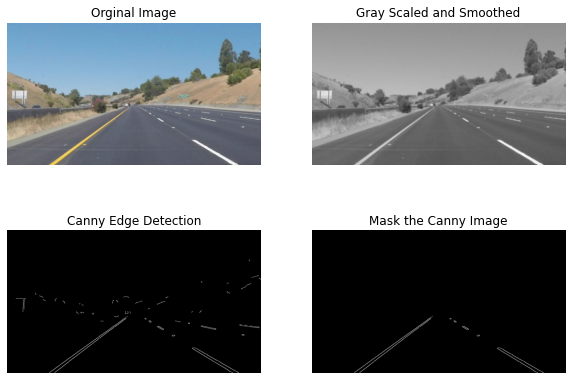

In [94]:
fig = plt.figure(figsize=(10, 7))
rows,columns = (2,2)

fig.add_subplot(rows, columns, 1)
# showing image
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Orginal Image")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(cv2.cvtColor(smoothed_img,cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Gray Scaled and Smoothed")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(cv2.cvtColor(canny_img,cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Canny Edge Detection")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(cv2.cvtColor(masked_img,cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Mask the Canny Image")

In [95]:
def slope_lines(image,lines):
    
    img = image.copy()
    poly_vertices = []
    order = [0,1,3,2]

    left_lines = [] #  / bu egimli cizgiler
    right_lines = [] #  \ bu egimli cizgiler
    for line in lines:
        for x1,y1,x2,y2 in line:

            if x1 == x2:
                pass #dikey cizgiler
            else:
                m = (y2 - y1) / (x2 - x1)
                c = y1 - m * x1

                if m < 0:
                    left_lines.append((m,c))
                elif m >= 0:
                    right_lines.append((m,c))

    left_line = np.mean(left_lines, axis=0)
    right_line = np.mean(right_lines, axis=0)

    print(left_line, right_line)

    for slope, intercept in [left_line, right_line]:

        rows, cols = image.shape[:2]
        y1= int(rows) 

        #y2 degeri: gercek height degerinin %60 ustu ya da y1 degerinin %60 altidir
        y2= int(rows*0.6) #int(0.6*y1)

        #Dogru denklemi y=mx +c bu sekilde de ifade edebiliriz x=(y-c)/m
        x1=int((y1-intercept)/slope)
        x2=int((y2-intercept)/slope)
        poly_vertices.append((x1, y1))
        poly_vertices.append((x2, y2))
        draw_lines(img, np.array([[[x1,y1,x2,y2]]]))
    
    poly_vertices = [poly_vertices[i] for i in order]
    cv2.fillPoly(img, pts = np.array([poly_vertices],'int32'), color = (0,155,100))
    return cv2.addWeighted(image,0.7,img,0.4,0.)
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):

    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    justLines=line_img.copy()
    line_img = slope_lines(line_img,lines)
    return justLines,line_img

- **hough_lines()** fonksiyonuyla Canny edge detector ile belirlediğimiz kenarları çizgi olarak elde ediyoruz

- Ulaştığımız çizgileri yatay mı dikey mi (eğer dikeyse solda mı sağda mı) diye ayırıyoruz

- Tabiki birden fazla çizgi tespit edilecek sağ tarafta olanları kendi arasında sol tarafta olanları kendi arasında gruplayarak iki ayrı çizgi elde etmeye çalışıyoruz

- Sonra bu iki çizgi arasını yeşil renkle boyuyoruz


In [96]:
def weighted_img(img, initial_img, a=0.1, b=1., c=0.):
    return cv2.addWeighted(initial_img, a, img,b, c)

**addWeighted()** fonksiyonuyla resimler arasındaki opaklığı ayarlayarak belirlenmiş bölgeyle orijinal resimi blend ediyoruz

In [97]:
    #Cizgelere Hough Transform uygula
    justLines,houghed_lines = hough_lines(img = masked_img, rho = 1, theta = np.pi/180, threshold = 20, min_line_len = 20, max_line_gap = 180)
    #Kenarlara Cizgi Ciz
    output = weighted_img(img = houghed_lines, initial_img = image, a=0.8, b=1., c=0.)

[ -0.74031328 663.85953788] [ 0.58557332 30.85141857]


Text(0.5, 1.0, 'Mix the Original and Detected Img')

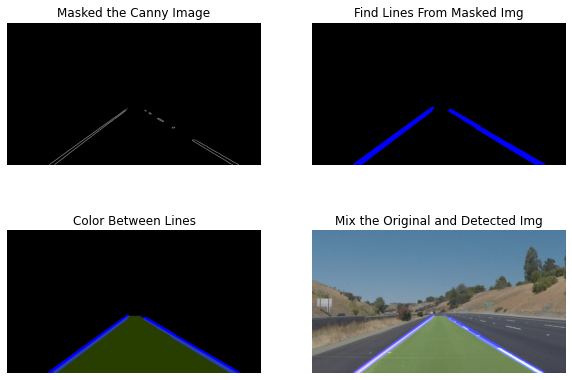

In [98]:
fig = plt.figure(figsize=(10, 7))
rows,columns = (2,2)

fig.add_subplot(rows, columns, 1)
# showing image
plt.imshow(cv2.cvtColor(masked_img,cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Masked the Canny Image")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(cv2.cvtColor(justLines,cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Find Lines From Masked Img")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(cv2.cvtColor(houghed_lines,cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Color Between Lines")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(cv2.cvtColor(output,cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Mix the Original and Detected Img")

In [99]:
def detect_line(image):  
    #Grayscale
    gray_img = grayscale(image)
    
    #Gaussian Blur
    smoothed_img = gaussian_blur(img = gray_img, kernel_size = 5)
    #Canny Edge Detection
    canny_img = canny(img = smoothed_img, low_threshold = 180, high_threshold = 240)
    #Maskelenmis Resim elde et
    masked_img = region_of_interest(img = canny_img, vertices = get_vertices(image))
    #Cizgelere Hough Transform uygula
    _,houghed_lines = hough_lines(img = masked_img, rho = 1, theta = np.pi/180, threshold = 20, min_line_len = 20, max_line_gap = 180)
    #Kenarlara Cizgi Ciz
    output = weighted_img(img = houghed_lines, initial_img = image, a=0.8, b=1., c=0.)
    
    return output

[ -0.80367214 691.86525043] [ 0.57278626 33.13205845]


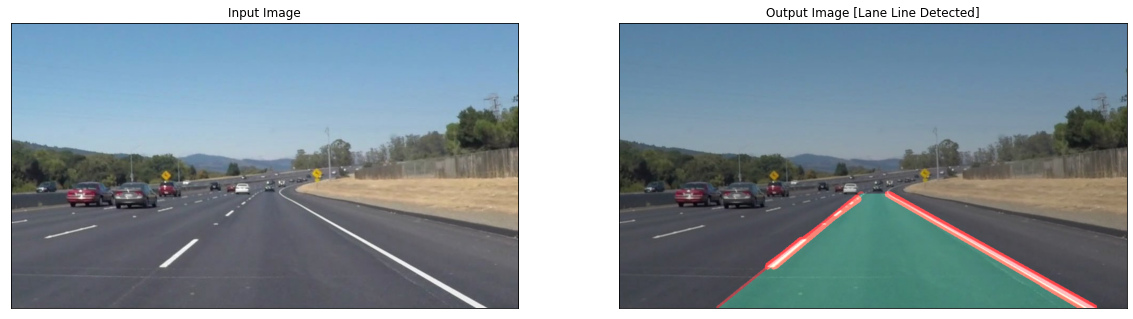

[ -0.70722619 646.68756969] [ 0.64353083 -1.93621793]


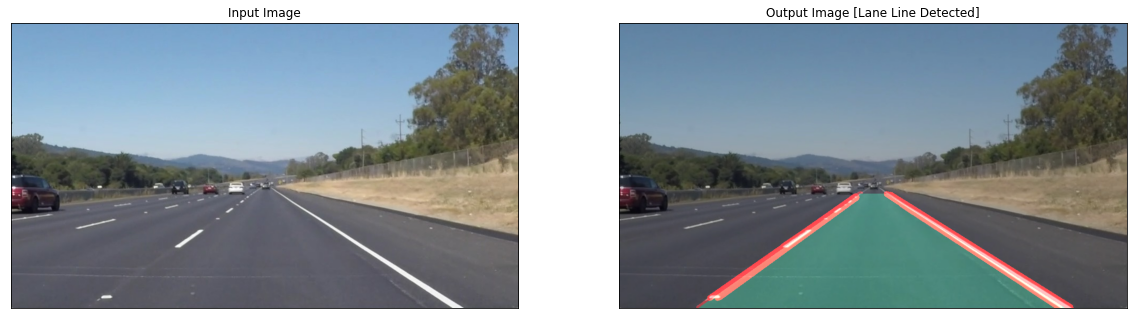

[ -0.70205846 646.06231573] [ 0.59158939 31.51032335]


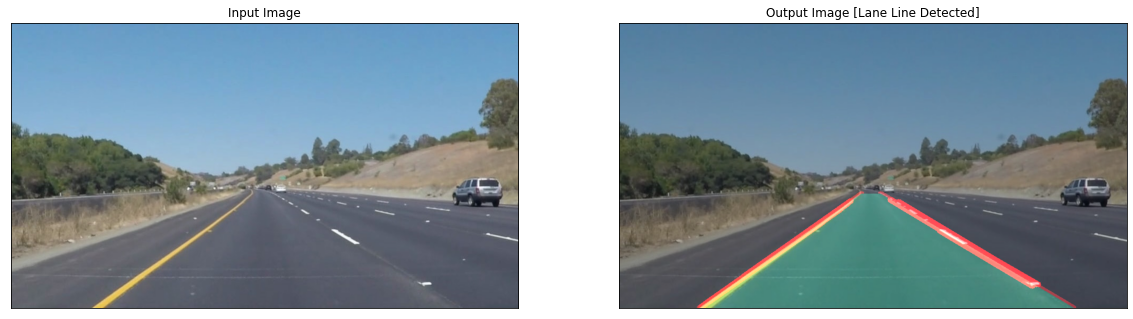

[ -0.73757767 661.91477168] [ 0.5850639  30.79678686]


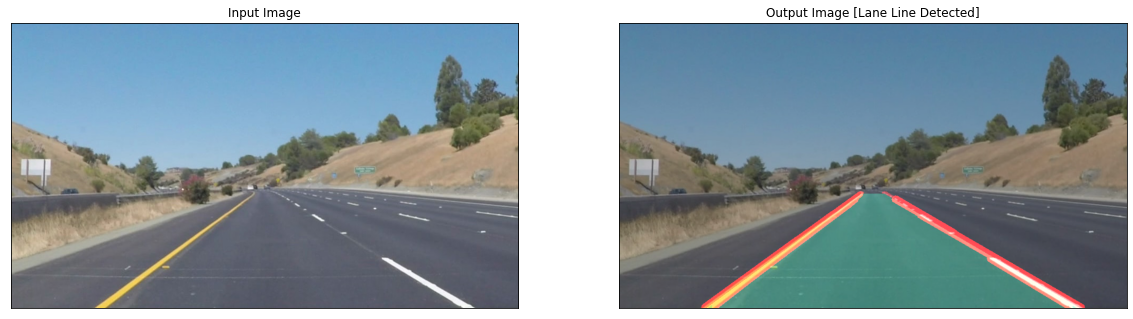

'\nfrom google.colab.patches import cv2_imshow\n\ncapture = cv2.VideoCapture(\'/content/test1.mp4\')\n\nfor i in range(450):\n    err,frame = capture.read()\n    if i%30==0:\n      fig = plt.figure(figsize=(20, 10))\n      image =frame\n      ax = fig.add_subplot(1, 2, 1,xticks=[], yticks=[])\n      plt.imshow(image)\n      ax.set_title("Input Image")\n      ax = fig.add_subplot(1, 2, 2,xticks=[], yticks=[])\n      plt.imshow(detect_line(image))\n      ax.set_title("Output Image [Lane Line Detected]")\n      plt.show()\n'

In [100]:

paths=['/content/1.jpg','/content/2.jpg','/content/3.jpg','/content/4.jpg']

for image_path in paths:
    fig = plt.figure(figsize=(20, 10))
    image = mpimg.imread(image_path)
    ax = fig.add_subplot(1, 2, 1,xticks=[], yticks=[])
    plt.imshow(image)
    ax.set_title("Input Image")
    ax = fig.add_subplot(1, 2, 2,xticks=[], yticks=[])
    plt.imshow(detect_line(image))
    ax.set_title("Output Image [Lane Line Detected]")
    plt.show()

"""
from google.colab.patches import cv2_imshow

capture = cv2.VideoCapture('/content/test1.mp4')

for i in range(450):
    err,frame = capture.read()
    if i%30==0:
      fig = plt.figure(figsize=(20, 10))
      image =frame
      ax = fig.add_subplot(1, 2, 1,xticks=[], yticks=[])
      plt.imshow(image)
      ax.set_title("Input Image")
      ax = fig.add_subplot(1, 2, 2,xticks=[], yticks=[])
      plt.imshow(detect_line(image))
      ax.set_title("Output Image [Lane Line Detected]")
      plt.show()
"""